In [ ]:
None

In [1]:
!pip install yfinance
!pip install yahoofinancials
!pip install quandl
!pip install PyPortfolioOpt

In [3]:
## Cargar todos los paquetes que usamos en este notebook
import numpy as np
from scipy import stats
import pandas as pd
from numpy import random
from numpy import linalg
from matplotlib import pyplot as plt
import yfinance as yf
from yahoofinancials import YahooFinancials
import quandl
import statistics
import seaborn as sns
from numpy import log
import datetime

In [4]:
def GeneraTablaAccionesLimpia(NombresAcciones,Desde,Hasta,
                              DatoEsperado = 'Close',
                              Periodo = '1d'):
    
    
    

  ##  Esta función requiere que le pasemos una serie de acciones como strings
  ##  y nos devolverá un data frame con los precios de estas, en las fechas que
  ##  tengan en común.
  
  # descargo el archivo del primer nombre

    DfPrecios =  yf.download(NombresAcciones[0],
                             start=Desde,
                             end=Hasta, 
                             progress=False,
                             interval = Periodo)

                    
    if (np.sum(DfPrecios.columns.isin([DatoEsperado])) == 0):
        return "El dato " + DatoEsperado + " no viene en la tabla de " + NombresAcciones[0]
  
  
    # tomo el dato que me interesa
    DfPrecios = DfPrecios[[DatoEsperado]]
  
    # Lo renombro con el nombre de la acción
    DfPrecios = DfPrecios.rename({DatoEsperado:NombresAcciones[0]},
                               axis = 'columns')

  # si tengo mas de una acción debo iterar
    if(len(NombresAcciones) > 1):
        for i in NombresAcciones[1:]:
            # Repito los primeros pasos
            DfTemporal = yf.download(i, 
                                    start=Desde, 
                                    end=Hasta, 
                                    progress=False,
                                    interval = Periodo)
            ##   agregamos una validación de los nombres de las columnas con el que
            ##    buscamos
            if (np.sum(DfTemporal.columns.isin([DatoEsperado])) == 0):
                return "El dato " + DatoEsperado + " no viene en la tabla de " + i
                

            #DfTemporal.set_index('Date', inplace = True)
            DfTemporal = DfTemporal[[DatoEsperado]]


            ## Aquí voy a empesar a fusionar los data frames (merge)

            DfPrecios = pd.merge(DfPrecios,DfTemporal,
                                left_index = True,
                                right_index = True)
            ## renombro la columna
            DfPrecios = DfPrecios.rename({DatoEsperado:i}, axis = 'columns')
        
    return DfPrecios


def GeneraRendimientosAcciones(NombresAcciones ,Desde, Hasta, TipoRendimiento = 'geometrico',
                               Periodo = '1d'):
    
  ## esta función recibe los nombres de las acciones y devuelve un data frame con
  ## sus rendimientos geométrico o aritmetico.

  ## Primero necesitamos los precios
    Precios = GeneraTablaAccionesLimpia(NombresAcciones,Desde,Hasta,'Close',Periodo)

    if TipoRendimiento == 'geometrico':
        Rendimientos = np.log(Precios.pct_change() + 1)

    elif TipoRendimiento == 'aritmetico':
        Rendimientos = Precios.pct_change()

    else:
        return "No se calcular el tipo de rendimiento " + TipoRendimiento

    return Rendimientos.iloc[1:,:]

NombresAcciones = ['AAPL','FB','MSFT','XOM',"^GSPC"]

In [5]:
Acciones=GeneraTablaAccionesLimpia(NombresAcciones,'2020-01-01','2022-01-01',
                              DatoEsperado = 'Close',
                              Periodo = '1d')
Acciones.head()

,AAPL,FB,MSFT,XOM,^GSPC
Date,,,,,
2020-01-02,75.087502,209.779999,160.619995,70.900002,3257.850098
2020-01-03,74.357498,208.669998,158.619995,70.330002,3234.850098
2020-01-06,74.949997,212.600006,159.029999,70.870003,3246.280029
2020-01-07,74.597504,213.059998,157.580002,70.290001,3237.179932
2020-01-08,75.797501,215.220001,160.089996,69.230003,3253.050049


<AxesSubplot:xlabel='Date'>

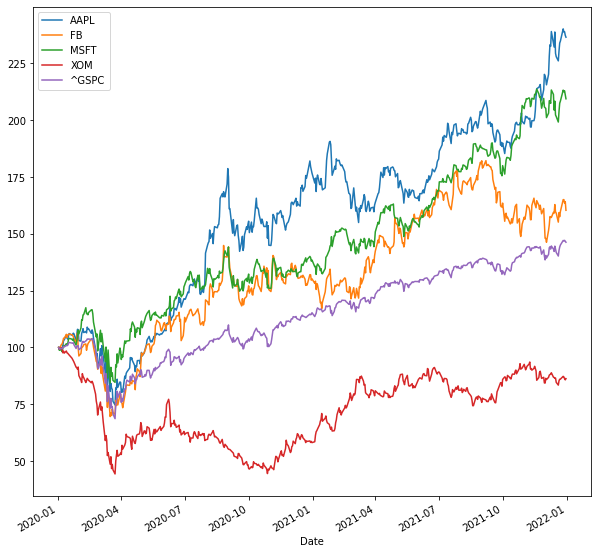

In [6]:
(Acciones/Acciones.iloc[0]*100).plot(figsize=(10,10))

In [7]:
log_ret=np.log(Acciones/Acciones.shift(1)).dropna()
log_ret.head()

,AAPL,FB,MSFT,XOM,^GSPC
Date,,,,,
2020-01-03,-0.009770,-0.005305,-0.012530,-0.008072,-0.007085
2020-01-06,0.007937,0.018658,0.002581,0.007649,0.003527
2020-01-07,-0.004714,0.002161,-0.009160,-0.008218,-0.002807
2020-01-08,0.015958,0.010087,0.015803,-0.015195,0.004890
2020-01-09,0.021018,0.014210,0.012416,0.007626,0.006633


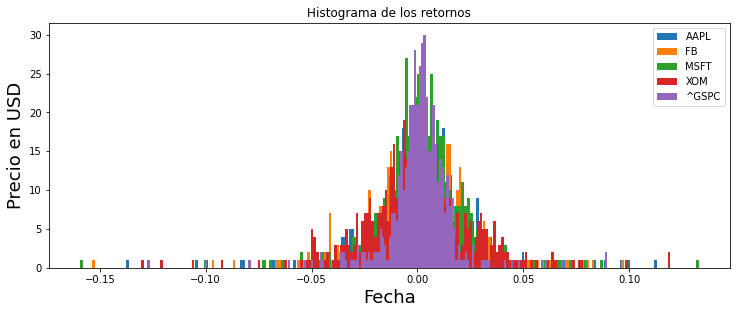

In [8]:
plt.figure(figsize=(12.2,4.5)) 
for i in log_ret.columns.values:
    plt.hist( log_ret[i],  label=i, bins = 200)
plt.title('Histograma de los retornos')
plt.xlabel('Fecha',fontsize=18)
plt.ylabel('Precio en USD',fontsize=18)
plt.legend(log_ret.columns.values)
plt.savefig('plotretornosnormales.png', dpi=300, bbox_inches='tight')
plt.show()

In [9]:
df_activos=log_ret.loc[:,log_ret.columns !='^GSPC']
df_activos.head()

,AAPL,FB,MSFT,XOM
Date,,,,
2020-01-03,-0.009770,-0.005305,-0.012530,-0.008072
2020-01-06,0.007937,0.018658,0.002581,0.007649
2020-01-07,-0.004714,0.002161,-0.009160,-0.008218
2020-01-08,0.015958,0.010087,0.015803,-0.015195
2020-01-09,0.021018,0.014210,0.012416,0.007626


In [10]:
df_benchmark1 =  log_ret.loc[:,log_ret.columns == '^GSPC']
df_benchmark1.head()

,^GSPC
Date,
2020-01-03,-0.007085
2020-01-06,0.003527
2020-01-07,-0.002807
2020-01-08,0.004890
2020-01-09,0.006633


In [12]:
import pypfopt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

In [13]:
retornos1 = expected_returns.capm_return(Acciones[['AAPL','FB','MSFT','XOM']], market_prices = Acciones[['^GSPC']],returns_data=False, risk_free_rate=0.02, frequency=252,log_returns=True )
retornos1

AAPL    0.189254
FB      0.172897
MSFT    0.186096
XOM     0.180948
Name: mkt, dtype: float64

In [14]:
np.random.seed(50)
num_ports = 6000
all_weights = np.zeros((num_ports, len(df_activos.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for x in range(num_ports):
    # Weights
    weights = np.array(np.random.random(len(df_activos.columns)))
    weights = weights/np.sum(weights)
    
    # Save weights
    all_weights[x,:] = weights
    
    # Expected return
    ret_arr[x] = np.sum( ((df_activos.mean() * weights)))
    
    # Expected volatility
    vol_arr[x] = np.sqrt(np.dot(np.dot(weights.T, df_activos.cov()), weights))
    # Sharpe Ratio
    sharpe_arr[x] = ret_arr[x]*(252**(1/2))/vol_arr[x]



In [15]:
print('El Sharpe Ratio máximo del arreglo es : {}'.format(sharpe_arr.max()))
print('El lugar en el arreglo es: {} '.format(sharpe_arr.argmax()))

El Sharpe Ratio máximo del arreglo es : 1.1675203353164612
El lugar en el arreglo es: 5168 


In [16]:



max_sr_ret=ret_arr[sharpe_arr.argmax()]
max_sr_vol=vol_arr[sharpe_arr.argmax()]

# Primer punto

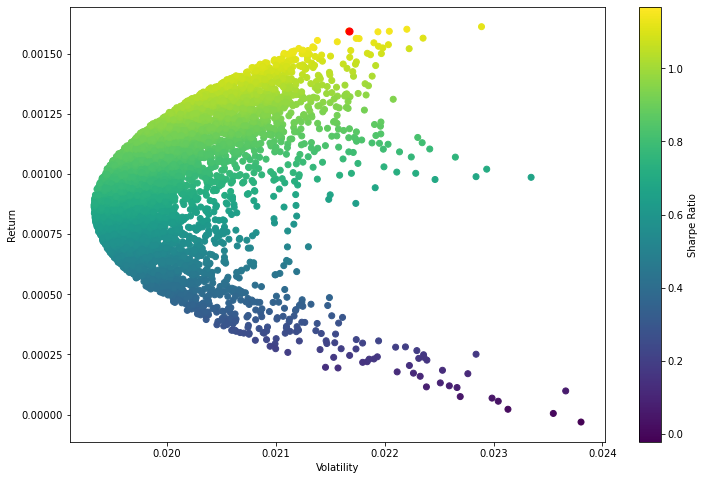

In [17]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.scatter(max_sr_vol, max_sr_ret,c='red', s=50) # red dot
plt.show()

# Segundo punto

In [18]:
# segundo punto
optimal_weights=all_weights[sharpe_arr.argmax(),:]
print(optimal_weights)

[0.56522985 0.00572679 0.42554951 0.00349385]


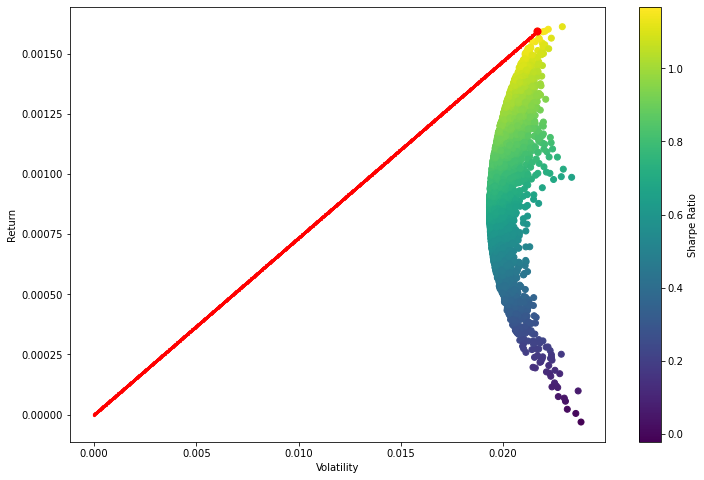

In [19]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.scatter(max_sr_vol, max_sr_ret,c='red', s=50) # red dot
plt.scatter(np.arange(0,max_sr_vol,max_sr_vol/1000),np.arange(0,max_sr_ret,max_sr_ret/1000),c='red',s=5)
plt.show()

# Tercer punto.


Se elige como benchmark el indicador "S&P 500" ya que representa el movimiento de la economía Estadounidense y ya que la mayoria de ETF's en el mercado intentan replicar este indicador. Por lo que un retorno por encima del S&P 500 suele ser bastante apetecido por el mercado. Ademas, en caso de que se quisiera replicar el indicador con el portafolio, bastaria con minimizar el tracking error de nuestro portafolio con respecto al benchmark,

In [20]:
## a continuacion la serie de retornos logaritmicos y de nivel del S&P500
Benchmark=Acciones[['^GSPC']]
Benchmark['retornos_bench']=Benchmark['^GSPC'].pct_change()
Benchmark['log_retornos_bench']=np.log(Benchmark['retornos_bench']+1)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [21]:
Benchmark.head()

,^GSPC,retornos_bench,log_retornos_bench
Date,,,
2020-01-02,3257.850098,NaN,NaN
2020-01-03,3234.850098,-0.007060,-0.007085
2020-01-06,3246.280029,0.003533,0.003527
2020-01-07,3237.179932,-0.002803,-0.002807
2020-01-08,3253.050049,0.004902,0.004890


# Cuarto punto

In [22]:
optimal_portfolio_returns=np.dot(df_activos,optimal_weights)
return_difference = optimal_portfolio_returns - Benchmark['log_retornos_bench'].dropna().tolist()
volatility = return_difference.std()

information_ratio = return_difference.mean()* np.sqrt(252) / volatility


In [23]:
print(f'el information ratio para el portafolio que maximiza el sharpe ratio con respecto al S&P500 es : {information_ratio}')

el information ratio para el portafolio que maximiza el sharpe ratio con respecto al S&P500 es : 1.1977726928211343


# Quinto punto

In [24]:
#window maker monthly
window_size=30
data_len=len(df_activos)
iterators=data_len-window_size

information_ratio_arr=[]
sharpe_ratio_arr=[]
for i in range(iterators):
    data_window=df_activos.iloc[(data_len-window_size-i):(data_len-i),:]
    benchmark_window=Benchmark.iloc[(data_len-window_size-i):(data_len-i),2].dropna()
    
    window_returns=np.dot(data_window,optimal_weights)
    vol_win = np.sqrt(np.dot(np.dot(optimal_weights.T, df_activos.cov()), optimal_weights))
    
    return_difference_window = window_returns - benchmark_window.tolist()
    volatility_win_diff = return_difference_window.std()
    
    information_ratio_arr.append(return_difference_window.mean()* np.sqrt(252) / volatility_win_diff)
    sharpe_ratio_arr.append(window_returns.mean()*np.sqrt(252)/vol_win)
    

In [25]:
information_ratio_arr

[1.5803687012106196,
 1.777942969185406,
 2.204773870619132,
 1.9431511430378317,
 2.7875026758783235,
 2.6344690197962337,
 2.401904532540466,
 2.4181714984915765,
 1.495661314858611,
 1.3952652315940144,
 1.1602835740073385,
 2.9914803898592086,
 2.348927097740713,
 2.406641980469629,
 2.986556827525921,
 2.644069846433908,
 3.3691091904291723,
 3.6758131827188123,
 3.0380926994637307,
 1.9040252258770483,
 3.3275669727111445,
 2.7375474685405843,
 2.383931338490539,
 2.687245061818659,
 0.5465736104764373,
 3.4273021943758235,
 3.6757638839412334,
 3.5468166930058143,
 3.644274502530459,
 2.562846918494946,
 1.6981090810923736,
 1.370722668756677,
 2.3212533974662866,
 0.7623752491240755,
 1.317341183250806,
 0.4657114850329969,
 2.0381930929047503,
 0.9220936068898586,
 0.5701293445031432,
 0.2503822574863345,
 0.29076571056778544,
 0.7409136602971598,
 1.1759510890268743,
 1.0497123257631018,
 0.8275345583866742,
 -0.19911902985972504,
 -0.10676986261318118,
 -0.25402357084936594,

#### E(x)

In [26]:
print(f'El valor esperado del information ratio calculado diariamente con una ventana de {window_size} dias es: {np.mean(information_ratio_arr)}')
print(f'El valor esperado del sharpe ratio calculado diariamente con una ventana de {window_size} dias es: {np.mean(sharpe_ratio_arr)}')


El valor esperado del information ratio calculado diariamente con una ventana de 30 dias es: 0.654594703313567
El valor esperado del sharpe ratio calculado diariamente con una ventana de 30 dias es: 1.1181184575914056


#### Var(x)

In [27]:
print(f'La varianza del information ratio calculado diariamente con una ventana de {window_size} dias es: {np.var(information_ratio_arr)}')
print(f'La varianza del sharpe ratio calculado diariamente con una ventana de {window_size} dias es: {np.var(sharpe_ratio_arr)}')


La varianza del information ratio calculado diariamente con una ventana de 30 dias es: 2.2687760351481137
La varianza del sharpe ratio calculado diariamente con una ventana de 30 dias es: 5.019417680351249


#### Skew(x)

In [28]:
print(f'La skewness del information ratio calculado diariamente con una ventana de {window_size} dias es: {stats.skew(information_ratio_arr)}')
print(f'La skewness del sharpe ratio calculado diariamente con una ventana de {window_size} dias es: {stats.skew(sharpe_ratio_arr)}')

La skewness del information ratio calculado diariamente con una ventana de 30 dias es: 0.4023168154384779
La skewness del sharpe ratio calculado diariamente con una ventana de 30 dias es: -0.9372185089935412


#### Kurtosis(x)

In [29]:
print(f'La kurtosis del information ratio calculado diariamente con una ventana de {window_size} dias es: {stats.kurtosis(information_ratio_arr)}')
print(f'La kurtosis del sharpe ratio calculado diariamente con una ventana de {window_size} dias es: {stats.kurtosis(sharpe_ratio_arr)}')

La kurtosis del information ratio calculado diariamente con una ventana de 30 dias es: 0.4715470469649743
La kurtosis del sharpe ratio calculado diariamente con una ventana de 30 dias es: 1.879858926055249


#### Var al 5% de la distribución

In [30]:
print(f'El VaR al 5% del information ratio calculado diariamente con una ventana de {window_size} dias es: {np.percentile(information_ratio_arr,5)}')
print(f'El VaR al 5% del sharpe ratio calculado diariamente con una ventana de {window_size} dias es: {np.percentile(sharpe_ratio_arr,5)}')

El VaR al 5% del information ratio calculado diariamente con una ventana de 30 dias es: -1.8650054413333064
El VaR al 5% del sharpe ratio calculado diariamente con una ventana de 30 dias es: -2.10672710564885


#### Intervalo de confianza al 99% de la distribución. (Beta bajo supúesto de normalidad)

In [31]:
# Esta es una aproximación a lo que seria el intervalo de confianza al 99% de confianza cuando la distribución fuera lo suficientemente grande.
print(f'Para el information ratio calculado diariamente con una ventana de {window_size} dias, con una probabilidad del 99% estara en el siguiente rango: [{np.mean(information_ratio_arr)+stats.norm.ppf(0.005)*np.std(information_ratio_arr)},{np.mean(information_ratio_arr)+(stats.norm.ppf(0.995)*np.std(information_ratio_arr))}]. Para llegar a este resultado el valor de Beta deberia ser {(stats.norm.ppf(0.995)*np.std(information_ratio_arr))}')

Para el information ratio calculado diariamente con una ventana de 30 dias, con una probabilidad del 99% estara en el siguiente rango: [-3.2252370461418924,4.534426452769026]. Para llegar a este resultado el valor de Beta deberia ser 3.879831749455459


In [32]:
print(f'Para el sharpe ratio calculado diariamente con una ventana de {window_size} dias, con una probabilidad del 99% estara en el siguiente rango: [{np.mean(sharpe_ratio_arr)+stats.norm.ppf(0.005)*np.std(sharpe_ratio_arr)},{np.mean(sharpe_ratio_arr)+(stats.norm.ppf(0.995)*np.std(sharpe_ratio_arr))}]. Para llegar a este resultado el valor de Beta deberia ser {(stats.norm.ppf(0.995)*np.std(sharpe_ratio_arr))}')

Para el sharpe ratio calculado diariamente con una ventana de 30 dias, con una probabilidad del 99% estara en el siguiente rango: [-4.652784184670747,6.889021099853557]. Para llegar a este resultado el valor de Beta deberia ser 5.770902642262151


# Sexto punto

### interpretación
#### E(x)
Primero, dado el resultado del valor esperado del information ratio, se puede inferir que, dado que es positivo, en promedio nuestro portafolio tenderia a desempeñarse mejor que el benchmark, sin embargo, tal como nos diria la teoria, esto viene acompañado con un riesgo y es que nuestro portafolio es volatil con respecto al indicador. Por esta razón, a pesar de que nuestro portafolio se desempeña en promedio un poco mejor que el benchmark, si el objetivo es minimizar el tracking error, esta puede no ser la mejor opción.

Por otra parte, vemos que el sharpe ratio es en promedio de 1.11, por lo que nuestro portafolio no solo tiene retornos positivos, sino que, al tener un SR positivo y mayor que 1, alcanza a compénsar cada unidad de volatilidad extra por el retorno que genera.
#### V(x)
Dados los resultados de la varianza, podemos observar que tanto el information ratio como el sharpe ratio de nuestro portafolio tiene una volatilidad significativa. Es decir, si lo miramos en una ventana pequeña, nuestro portafolio puede no desempeñarse de la manera esperada dado el analisis de largo plazo. Por lo que en el corto plazo podria generar perdidas importanes o ganancias bastante significativas.
#### Skewness(x) and kurtosis(x)
El resultado del skew para el sharpe ratio nos dice, tal como se ve en la siguiente figura, que el SR es asimetrico hacia la izquierda, es decir, que su distribución es mas larga hacia ese lado, por lo cual, hay mas casos extremos en la cola izquierda que en la derecha de la distribución. Es decir, en los casos donde los resultados eran malos, eran bastante mas malos con respecto a la media que en el caso de los resultados positivos para el portafolio. En cuanto a la curtosis, vemos que el sharpe ratio tiene una kurtosis significativamente alta, por lo que tiene una cantidad importante de valores extremos, lo cual combinado con el resultado de la skewness nos dice que tiene una alta cantidad de valores extremos en la cola izquierda.
Por otra parte, para el information ratio se presenta el caso contrario que para el sharpe, ya que vemos que presenta una skewness positiva y una kurtosis tambien positiva pero en menos medida que el sharpe. Esto significa que son mas los casos en los que el portafolio se desempeña mejor que el benchmark y que tambien hay valores atipicamente positivos(con respecto al benchmark) para el portafolio. Esto lo que podria indicar es que las observaciones muy negativas del sharpe ratio puedan tener que ver con situaciones negativas en general para la economia (las cuales refleja el benchmark).

#### Analisis de VaR
Por ultimo, en cuanto a los riesgos de nuestro portafolio, vemos que con un 0,5% de probabilidad podriamos tener un sharpe Ratio de -4.65 y con una probabilidad de 5% podriamos tener un sharpe ratio de -2,10, lo cual serian resultados negativos para el portafolio porque estariamos perdiendo dinero. Por lo cual, es importante mantener un monitoreo constante del rendimiento del portafolio, ya que a pesar de que sea optimo bajo el modelo de CAPM(), depende mucho de la estimacion del retorno esperado y por lo tanto, es muy sensible a la calibraciòn de sus parametros.

##### Histograma para el sharpe Ratio

[[<AxesSubplot:title={'center':'0'}>]]


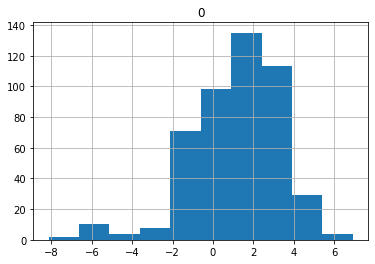

In [33]:
print(pd.DataFrame(sharpe_ratio_arr).hist())

##### Histograma para el information ratio

[[<AxesSubplot:title={'center':'0'}>]]


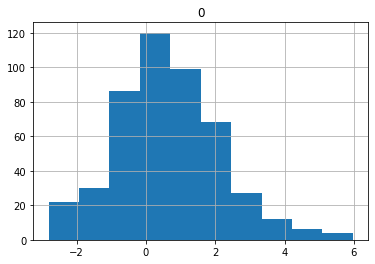

In [34]:
print(pd.DataFrame(information_ratio_arr).hist())